# 1. Install & Import Dependences


In [1]:
# !pip install tensorflow==2.8.1 tensorflow-gpu==2.8.1 opencv-python mediapipe sklearn matplotlib
# !pip install -U scikit-learn

In [125]:
import cv2
import mediapipe as mp
import numpy as np
from matplotlib import pyplot as plt
import os
import time
import sklearn

# 2. Keypoints using Mediapipe Holistic

In [126]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Holistic drawing utilities

In [127]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color Convertion
    # Image not writeable
    image.flags.writeable = False
    # Make prediction
    results = model.process(image)
    # Image is now writeable
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color Convertion
    return image, results

In [128]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [129]:
def draw_styled_landmarks(image, results):
    # Draw Face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
                              mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1),
                              mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                              )
    
    #     Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )    
    #     Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    #     Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )

In [130]:
#mp_drawing.draw_landmarks??

In [231]:
cap = cv2.VideoCapture(0) # Enter value (1).
# Seting mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        # reed feed
        ret, frame = cap.read()

        # make detection
        image, results = mediapipe_detection(frame, holistic)
        
        # draw landmark
        draw_styled_landmarks(image, results)

        # open webcam window
        cv2.imshow("Webcam Window", image)
        # break windows
        if cv2.waitKey(10) & 0xff == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [132]:
# drawing hand, pose, face landmarks
# draw_styled_landmarks(image, results)

In [133]:
# showing matplotlib created image output
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoints Values

In [134]:
pose=[]
for res in results.pose_landmarks.landmark:
    test = np.array([res.x,res.y,res.z, res.visibility])
    pose.append(test)

In [135]:
# Define numpy array function.
face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
pose = np.array([[res.x,res.y,res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [136]:
# len(face)
# (n=results.face_landmarks) need to change value on shall 17 np.zeros(n)

In [137]:
def extract_keypoints(results):
    face = np.array([[res.x,res.y,res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    pose = np.array([[res.x,res.y,res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x,res.y,res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x,res.y,res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([face, pose, lh, rh])
#     return np.concatenate([pose, lh, rh])

In [138]:
# Check all the kepoints
# extract_keypoints(results).shape

# math 
# 468*3+33*4+21*3+21*3

In [139]:
# Save Images/Videos on File path with ex .npy
# result_test = extract_keypoints(results)
# np.save('0', result_test)

# it will show the array
# np.load(0.npy)

# 4. Setup Folders for Data Collection

In [140]:
# path for exported/Collected data, numpy arrays
DATA_PATH = os.path.join('Collected_Data')

# Actions that we try to detect
actions = np.array(['A','B','C'])

# photos/videos are going to storeing limit 30
no_sequences = 15 # Change to 30
sequences_length = 15 # Change to 30

In [141]:
# Folder Stucture

# A
## 0 to ## 29 ==30
# B
## 0 to ## 29 ==30
# c
## 0 to ## 29 ==30
# .
# .
# .
# n
## 0 to ## 29 ==30

In [142]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect keypoint Values for Training & Testing

In [186]:
cap = cv2.VideoCapture(0) # Enter value (1).
# Seting mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # loop through actions
    for action in actions:
        # loop through sequences or a videos
        for sequence in range(no_sequences):
            # loop through video length or a sequences length
            for frame_num in range(sequences_length):
                                
                # read feed
                ret, frame = cap.read()

                # make detection
                image, results = mediapipe_detection(frame, holistic)

                # draw landmark
                draw_styled_landmarks(image, results)
                
                # Apply the self folder changing & data collection logic
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTIONS', (120, 200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} video Number{}'.format(action, sequence),(15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.waitKey(2000)
                    
                    
                else:
                    cv2.putText(image, 'Collecting frames for {} video Number{}'.format(action, sequence), (15,12),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                   
                
                # Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # open webcam window
                cv2.imshow("Collection Window", image)
            # break windows
            if cv2.waitKey(10) & 0xff == ord('q'):
                break
                
    cap.release()
    cv2.destroyAllWindows()


# 6. Data preprocessing  & Create Lables and Features

In [187]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [188]:
label_map = {label:num for num, label in enumerate(actions)}

In [189]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequences_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [190]:
# how many shape in each frame
np.array(sequences).shape

(45, 15, 1662)

In [191]:
x = np.array(sequences)
y = to_categorical(labels).astype(int)

In [192]:
# training & testing
x_train, x_test , y_train, y_test = train_test_split(x, y, test_size=0.5)

# 7. Build and Train LSTM Neural Network

In [193]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [194]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [195]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [196]:
# x.shape
# y.shape
# actions.shape[0]

In [197]:
# finding labels
res =[.7, 0.2, 0.1]
actions[np.argmax(res)]

'A'

In [198]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [199]:
model.fit(x_train, y_train, epochs=100, callbacks=[tb_callback])

Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 1.1306 - categorical_accuracy: 0.2273
Epoch 2/100
1/1 [==============================] - 0s 175ms/step - loss: 1.0783 - categorical_accuracy: 0.2273
Epoch 3/100
1/1 [==============================] - 0s 115ms/step - loss: 1.0568 - categorical_accuracy: 0.3182
Epoch 4/100
1/1 [==============================] - 0s 116ms/step - loss: 1.4558 - categorical_accuracy: 0.1818
Epoch 5/100
1/1 [==============================] - 0s 119ms/step - loss: 2.6773 - categorical_accuracy: 0.3636
Epoch 6/100
1/1 [==============================] - 0s 119ms/step - loss: 3.0135 - categorical_accuracy: 0.3182
Epoch 7/100
1/1 [==============================] - 0s 121ms/step - loss: 3.0893 - categorical_accuracy: 0.2273
Epoch 8/100
1/1 [==============================] - 0s 121ms/step - loss: 3.3080 - categorical_accuracy: 0.4091
Epoch 9/100
1/1 [==============================] - 0s 116ms/step - loss: 5.2781 - categorical_accuracy: 0.4091
Epoc

1/1 [==============================] - 0s 117ms/step - loss: 0.5416 - categorical_accuracy: 0.8182
Epoch 75/100
1/1 [==============================] - 0s 128ms/step - loss: 0.7595 - categorical_accuracy: 0.5455
Epoch 76/100
1/1 [==============================] - 0s 122ms/step - loss: 0.4724 - categorical_accuracy: 0.8636
Epoch 77/100
1/1 [==============================] - 0s 132ms/step - loss: 0.7293 - categorical_accuracy: 0.6818
Epoch 78/100
1/1 [==============================] - 0s 123ms/step - loss: 0.5188 - categorical_accuracy: 0.8182
Epoch 79/100
1/1 [==============================] - 0s 120ms/step - loss: 0.4449 - categorical_accuracy: 0.8182
Epoch 80/100
1/1 [==============================] - 0s 122ms/step - loss: 0.5987 - categorical_accuracy: 0.7273
Epoch 81/100
1/1 [==============================] - 0s 121ms/step - loss: 0.3981 - categorical_accuracy: 0.8636
Epoch 82/100
1/1 [==============================] - 0s 121ms/step - loss: 0.4347 - categorical_accuracy: 0.8182
Epoch

In [200]:
# for training model
# inside command promt

# cd F:\Jupyter_notebook\SignLanguageDetection\Logs\train
# tensorboard --logdir=.

# now open
# http://localhost:6006/

In [201]:
# model train summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 15, 128)           916992    
                                                                 
 lstm_13 (LSTM)              (None, 15, 64)            49408     
                                                                 
 lstm_14 (LSTM)              (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 3)                 99        
                                                                 
Total params: 1,005,763
Trainable params: 1,005,763
No

# 8. Make predictions

In [202]:
res = model.predict(x_test)

In [203]:
actions[np.argmax(res[0])]

'B'

In [204]:
actions[np.argmax(y_test[0])]

'B'

# 9. Save Weights

In [205]:
model.save('action.h5')

In [206]:
# delete and reload
# del model

In [207]:
# reload model
# model.load_weights(action.h5)

# 10. Evaluation using Confusion Matrix and Accuracy

In [208]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [209]:
yhat = model.predict(x_test)

In [210]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat,axis=1).tolist()

In [211]:
ytrue

[1, 0, 1, 0, 2, 0, 2, 1, 1, 2, 2, 1, 2, 2, 0, 0, 0, 2, 2, 1, 0, 0, 2]

In [212]:
# multilabel_confusion_matrix?

In [213]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[15,  0],
        [ 1,  7]],

       [[16,  1],
        [ 3,  3]],

       [[11,  3],
        [ 0,  9]]], dtype=int64)

In [214]:
# score 1 is 100% accuracy of the model
accuracy_score(ytrue, yhat)
accur = accuracy_score(ytrue, yhat)

In [215]:
print(accur)

0.8260869565217391


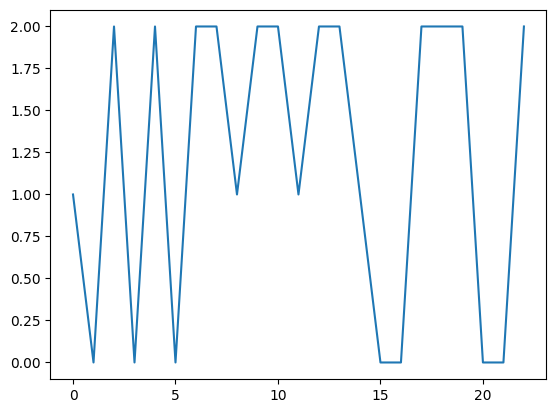

In [216]:
plt.plot(yhat)

# 11. Test in Real Time

In [217]:
# testing sequences
np.expand_dims(x_test[0], axis=0)

array([[[ 0.80334532,  0.58310384, -0.04147979, ...,  0.20047072,
          0.30202731, -0.05534538],
        [ 0.77901042,  0.58290404, -0.03958085, ...,  0.24157204,
          0.32389724, -0.03537457],
        [ 0.78123635,  0.58277708, -0.03978064, ...,  0.24090481,
          0.31964722, -0.05042778],
        ...,
        [ 0.78699845,  0.58603597, -0.03911341, ...,  0.24245787,
          0.3162258 , -0.06086006],
        [ 0.78774488,  0.58510262, -0.03914823, ...,  0.24123633,
          0.31466302, -0.06520607],
        [ 0.78895116,  0.58462828, -0.03880743, ...,  0.24085014,
          0.31272128, -0.04646923]]])

In [218]:
# (num_sequences,30,1662)

In [219]:
model.predict(np.expand_dims(x_test[0], axis=0))

array([[0.00280947, 0.9905799 , 0.00661063]], dtype=float32)

In [220]:
from scipy import stats

In [221]:
# probabitity vizualization function
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

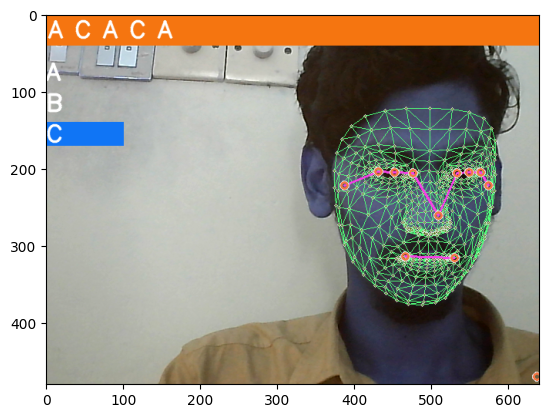

In [229]:
plt.imshow(prob_viz(res, actions, image, colors))


In [228]:
model.predict(np.expand_dims(sequence, axis=0))[0].shape

(3,)

In [224]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
#             print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('prediction window', image)
        print(accur)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565217391
0.8260869565

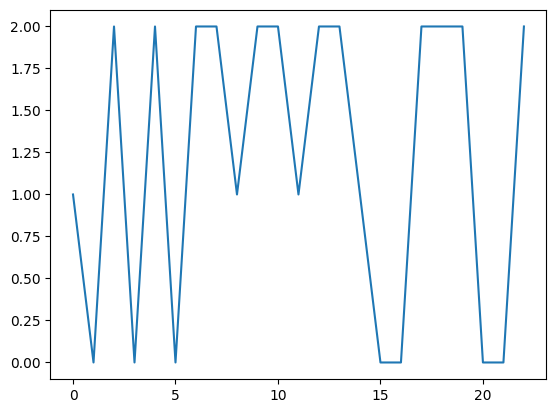

In [225]:
plt.plot(yhat)

In [226]:
# if we get an error we need to run this shell
cap.release()
cv2.destroyAllWindows()

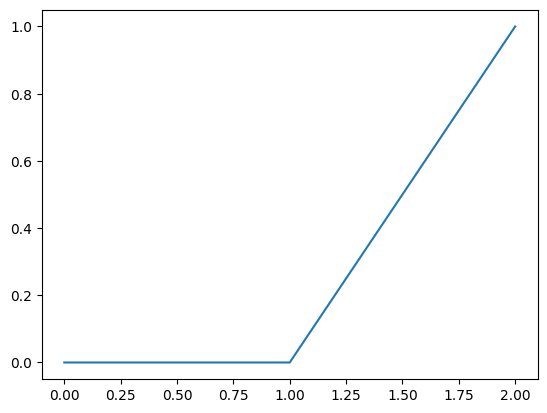

In [227]:
plt.plot(res)